[**INTRODUCTION TO PYRO**](http://pyro.ai/examples/intro_long.html)

# Setup

## Modules

In [1]:
import logging
import typing

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

import pyro
import pyro.distributions as dist

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 17 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

logging   : 0.5.1.2
matplotlib: 3.4.3
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
seaborn   : 0.11.2
pyro      : 1.8.0
torch     : 1.10.0
pandas    : 1.3.4
numpy     : 1.21.2

Watermark: 2.3.0



In [3]:
# Pyro version
assert pyro.__version__.startswith('1.8.0')

# Pyro settings
pyro.enable_validation(True)
pyro.set_rng_seed(1)

# Logging settings
log = logging.getLogger('basic')
log.setLevel(logging.DEBUG)
log_handler = logging.StreamHandler()
log_handler.setFormatter(logging.Formatter('{asctime} | {message}', style="{"))
log.addHandler(log_handler)
log.debug('Try log')

# Set plotting settings
%matplotlib inline
plt.style.use('default')

2022-01-17 13:34:28,186 | Try log


# Background

## Probabilistic models

* Funny statement: data analysis problems may be understood by answering 3 questions:
    * What do we **know** about the problem **before seeing the data**?
    * What **conslusions** can we **take from data** *given* our **prior knowledge**?
    * Do the **conslusions make sense**?

* In order to approach the problem probabilistically, we need to:
    * Setting a `probabilistic model`, by defining:
        * The `variables` in a problem
        * The `relationships` between them **&/or** a `joint probability distribution` over the collection of variables

* `Variables` could be further divided between:
    * `Observed variables`: the ones one can **get data on/instances of** - call it $x$
    * `Latent variables`: said unobserved, the ones **we don't have instances of** - call it $z$

* When building a `generative model` of the problem/process, one is to give a `joint probability distribution` over the variables, with some additional parameters $\theta$, i.e.:
    * a `prior` for the `latent variables`: $p_\theta(z)$
    * a `likelihood` for seeing `observed variables` given the `latent`: $p_\theta(x|z)$
    * finally, the joint: $$p_\theta(x, z) = p_\theta(x|z) \times p_\theta(z)$$

* Inference on the `latent variables`, considering the data on the `observed` ones, is then carried by finding the `posterior`: $$p_\theta(z|x)=\frac{p_\theta(x,z)}{p_\theta(x)}=\frac{p_\theta(x|z)p_\theta(z)}{\int p_\theta(x,z) dz}$$

* The `true posterior` is intractable to calculate for any non-trivial problem - for the integral -, but there are many *approximate inference* methods developed to approximate it:
    * Grid
    * Monte Carlo
    * Laplace/quadratic
    * Variational

* `Variational inference` methods usually require that (considering the probabilities $p_i$ that make up $p_\theta(x,z)$):
    * one can efficiently **sample** from $p_i$
    * one can efficiently **compute the pointwise probability density** $p_i$
    * $p_i$ is differentiable wrt the parameters $\theta$

* One can then do **predictions for new data**, via the `posterior predictive distribution`: 
$$p_\theta(x'|x) = \int_z p_\theta(z,x'|x) = \int_z p_\theta(x'|z)p_\theta(z|x)$$

* One can also find the parameters $\theta$ that maximize `evidence`, i.e, find:
$$\theta_{\text{max}}=\argmax_\theta p_\theta(x) = \argmax_\theta \int_z p_\theta(x, z)$$

# Models in `pyro`

* `Pyro` models are specified as `python` functions that:
    * generate `observed data` from `latent variables` (and `parameters`?)
    * this is carried by the use of `pyro primitives` (more on later)

* A `pyro` model is then encoded via the correspondence:
    * `latent variable` $z$ $\Leftrightarrow$ `pyro.sample('z', <distribution>)`
    * `observable variable` $x$ $\Leftrightarrow$ `pyro.sample('x', <distribution>, obs=x)`
    * `learnable parameter` $\theta$ $\Leftrightarrow$ `pyro.param('theta', <value>, constraint=<constraint>)`
    * `plates` (to be talked) $\Leftrightarrow$ `pyro.plate` context manager

* As an example, consider the model:
    * $Z \sim Beta(a,b)$
    * $X|Z \sim Bernoulli(Z)$

* In which 
    * $a$ and $b$ are both `parameters` - that *influence* $Z$
    * $Z$ is a `latent variable`: could be, e.g., the *probability* of heads for a given coin
    * $X$ is an `observable variable`: could be, e.g., the *measurable* fact of whether the given coin lands heads

* A `pyro model` corresponding to the `likelihood` of $X$ could then be set as:

In [24]:
pyro.clear_param_store()
def coin_likelihood():
    # Set parameters
    a = pyro.param('a', torch.tensor(1))
    b = pyro.param('b', torch.tensor(1))
    
    # Sample latent variable
    z = pyro.sample('z', dist.Beta(a, b))
    
    # Sample observable variable
    x = pyro.sample('x', dist.Binomial(1, z))
    return x
    

* If we want to stress the fact that $X$ is an `observable variable` - for `pyro` machinery to work on - we then write:

In [25]:
pyro.clear_param_store()
def coin_joint(coin_result: typing.Literal[0,1]):
    # Set parameters
    a = pyro.param('a', torch.tensor(1), constraint=dist.constraints.positive)
    b = pyro.param('b', torch.tensor(1), constraint=dist.constraints.positive)
    
    # Sample latent variable
    z = pyro.sample('z', dist.Beta(a, b))
    
    # Sample observable variable
    x = pyro.sample('x', dist.Binomial(1, z), obs=torch.tensor(coin_result))
    return x

* Now, this function `coin_joint` does not work anymore to produce data samples of $X$: it will always output its input

In [27]:
[coin_joint(1) for i in range(5)]

[tensor(1), tensor(1), tensor(1), tensor(1), tensor(1)]

In [28]:
[coin_joint(0) for i in range(5)]

[tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)]

* But it tells `pyro` the relationship between the variables set with `param` and `sample` statements: be it parameters, latent variables, or observed variables

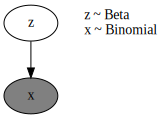

In [29]:
pyro.render_model(coin_joint, model_args=(1,), render_distributions=True)

* BEAUTIFUL!

# Pyro primitives

## `pyro.sample`

* `pyro.sample` is used to represent `primitive probability distributions` on both:
    * latent variables: by specifying its name, distribution, and observation (or later conditioning it)
    * observed variables: by specifying its name and distribution

* It is initialized with the signature:
```python
def sample(
    name: str,
    distribution: pyro.distributions.Distribution,
    *,
    obs: typing.Optional[torch.Tensor] = None,
    infer: typing.Optional[dict] = None
) -> torch.Tensor:
```

* In which:
    * the `name` kwarg is the name of the variable to represent
    * the `distribution` kwarg corresponds to its distribution
    * the `obs`, if set, is used to signal that the variable is *observed*, and stores the corresponding observation

* The statement 
```python
        pyro.sample('x', dist.Bernoulli(z))
```
works as a wraper on
```python
        dist.Bernoulli(z).sample()
```
in which `'x'` is also added to the `pyro` parameter store, for being used in `pyro`'s internals

* It basically represents to `pyro` that `x` is a variable conditioned on `z`, following the given distribution

* If we further wish to specify that `x` is an `observable variable`, we have 2 options:
* feeding the `obs` keyword with a value, as in:
```python
            pyro.sample('x', dist.Bernoulli(z), obs=x)
```

* later conditioning `'x'` on given values `x`, using the higher-order `pyro` primitive `condition`, in which:
    * `pyro.condition(coin_likelihood, data={'x': coin_result})` is basically equivalent to `coin_joint`

## `pyro.param`

* `pyro.param` may be regarded as the **frontend** with `pyro`'s [*parameter store*](https://docs.pyro.ai/en/stable/parameters.html#pyro.params.param_store.ParamStoreDict)

* It is initialized with the signature:
```python
pyro.param(
    name: str,
    *args,
    init: Optional[Union[torch.Tensor, Callable[..., torch.Tensor]]] = None,
    constraint: Optional[pyro.distributions.constraints.Constraint] = constraints.real
) -> torch.Tensor
```

* In which:
    * the `name` kwarg is required, and represents the key to the parameter store - if within a `pyro.module`, it is prefixed with the module's name
    * the `init` kwarg is the value for the first time the parameter is stored - if it is a callable, it takes the arguments given as *args
    * the `constraint` kwarg is the way in which the parameter values can be constrained, for training
    * `pyro` parameters are updated via optimization algorithms through some method we'll eventually see!

In [30]:
pyro.clear_param_store()
pyro.param('a', torch.ones((2,)))
pyro.param('b', torch.ones((4,)))

tensor([1., 1., 1., 1.], requires_grad=True)

In [31]:
pyro.param('a')

tensor([1., 1.], requires_grad=True)

In [32]:
# reassinging 'a' directly doesn't change the value, just returns the value that was stored!
pyro.param('a', torch.tensor(3))

tensor([1., 1.], requires_grad=True)

In [33]:
def try_model():
    c = pyro.param('c', torch.randn(3))
    return pyro.sample('out', dist.Normal(c, 1))
try_model()

tensor([ 2.0033, -0.6867, -1.1242], grad_fn=<AddBackward0>)

In [34]:
for item in pyro.get_param_store().items():
    log.info(f'Param store item: {item}')

2022-01-17 13:36:04,703 | Param store item: ('a', tensor([1., 1.], requires_grad=True))
2022-01-17 13:36:04,703 | Param store item: ('b', tensor([1., 1., 1., 1.], requires_grad=True))
2022-01-17 13:36:04,703 | Param store item: ('c', tensor([ 0.8662, -0.3528,  0.3482], requires_grad=True))


## `pyro.plate`

* `pyro.plate` is `pyro`'s *formal* representation of **plate notation** 

* It is initialized with the signature:
```python
def plate(
    name: str,
    size: int,
    *,
    dim: Optional[int] = None,
    **other_kwargs
) -> contextlib.AbstractContextManager:
```

* In which:
    * the `name` kwarg represents the name of a (usually multidimensional) variable
    * the `size` kwarg is then the dimension of the variable
    * the `dim` represents the block size (I guess)

* It can be used as:
```python
with pyro.plate("data", len(ruggedness)):
    return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```

# Inference

## Theory

* In this context, `inference` means leveraging information for divising:
    * the `posterior` distribution, i.e., the distribution over the latent variables
    * the `parameters` that maximize evidence of the data seen

* Apparently, `pyro` supports several exact and approximate inference algorithms, but the one with most support is `variational inference`

* The goal of `variational inference` is bi-headed:
    * finding $\theta_{\text{max}}$
    * finding the `variational distribution` $q_\phi(z)$ - a tractable approximation to the true unkown posterior $p_{\theta_\text{max}}(x|z)$

* The `variational distribution` $q_\phi(z)$ - called `guide` in `pyro` - is defined as:
    * belonging to some parameterized family of distributions $Q_\Phi = \{q_\phi: \phi \in \Phi\}$
    * being the closest (according to $\mathbb{KL}\text{-divergence}$) to the posterior distribution, i.e.:
    $$q_\phi(z) = \argmin_{\phi \in \Phi} \mathbb{KL}(q_\phi(z)||p_\theta(z|x))$$

* * Since the $\mathbb{KL}\text{-divergence}$, as is, is still intractable - it depends on the posterior (which is assumed intractable) - we can decompose it as:

$\begin{align}
\mathbb{KL}(q_\phi(z)||p_\theta(z|x)) & = \mathbb{E}_{q_\phi}[\log(\frac{q_\phi(z)}{p_\theta(z|x)})] \\
& = \mathbb{E}_{q_\phi}[\log(\frac{q_\phi(z)p_\theta(x)}{p_\theta(x,z)})] \\
& = \mathbb{E}_{q_\phi}[\log(q_\phi(z))]  - \mathbb{E}_{q_\phi}[\log(p_\theta(x,z))] + \log(p_\theta(x))
\end{align}$

* Then:
    * minimizing $\mathbb{KL}(q_\phi(z)||p_\theta(z|x))$ wrt $\phi$ amounts to minimize $\mathbb{E}_{q_\phi}[\log(q_\phi(z))]  - \mathbb{E}_{q_\phi}[\log(p_\theta(x,z))]$
    * since $\log(p_\theta(x))$ is a constant wrt $\phi$

* By defining $$\text{ELBO}(\phi, \theta)\equiv \mathbb{E}_{q_\phi}[\log(p_\theta(x,z))] - \mathbb{E}_{q_\phi}[\log(q_\phi(z))]$$
* We assert that `minimizing` $\mathbb{KL}(q_\phi(z)||p_\theta(z|x))$ equates to `maximizing` $\text{ELBO}(\phi, \theta)$

## Implementation in `pyro`

* We represent the `guide` in `pyro` the same way we do for the `model`, with the following characteristics:
    * the `guide` does not depend on the data - hence it has no `observation` data
    * the `guide` must have the same argument signature as the `model` - this is enforced by `pyro` itself
    * the `guide` must have a `pyro.sample` statement corresponding to each `latent variable` sampled in the model:
        * the names given to the variables must be the same in the `guide` and the `model`, in a 1-to-1 correspondence
        * the distributions may be (and usually are) different 

* `Pyro` also offers `autoguides` automatically generated from the `model`

## Inference algorithms

* Finding the maximizer of the $\text{ELBO}$ wrt $\phi$ and $\theta$ is an iterative process
* There are several methods for the iteration

* The main assumptions that `pyro`'s inference methods relly upon are:
    * the fact that the `guide` is a parameterized distribution from which we can sample from, such that:
        * we can compute Monte Carlo estimates of the $\text{ELBO}$
        * we can compute gradients of the $\text{ELBO}$ wrt $\phi$ and $\theta$, i.e., $\nabla_{\phi, \theta}\text{ELBO}$

* Optimizing the $\text{ELBO}$ over $\phi$ and $\theta$ via `stochastic gradient descent` is called `stochastic variational inverence`
* Hence, `pyro`'s main algorithm for finding $\phi$ and $\theta$ is encapsuled in the `SVI` class (more on later!)

# Example: coin bias

## problem statement

* access the fairness of a given coin in landing heads or tails

* knowledge of the coin:
    * issued by US mint
    * several years of use

* knowledge of the experiments:
    * the result of 10 trials was H, H, T, H, T, H, H, T, T, H : 6 heads out of 10 trials

## modelling in probabilistic terms

* we can observe whether the coin lands heads or tails - and we can represent that with a r.v. $x\in {0, 1}$, such that:
    * $x=1$ means the coin lands heads
    * $x=0$ otherwise

* we can encode the fairness of the coin as a `latent variable` $z\in\ ]0,1[$

* furthermore, it makes sense to encode the relashionship between $x$ and $z$ as:
$$x|z \sim Bernoulli(z)$$

* to encode the knowledge we have of $z$ in a probability distribution, we want to stress that it has higher probability of being fair that not, with support on the interval $[0,1]$ - for that we can use a beta distribution:
$$z \sim Beta(a,b)$$

* a different $a$ and $b$ would result in an assymetric distribution, and we don't have any evidence to favor that
* furthermore, the higher the values, the sharper the distribution is
* so a reasonable choice, given our *prior knowledge*, would be $a=b=8$

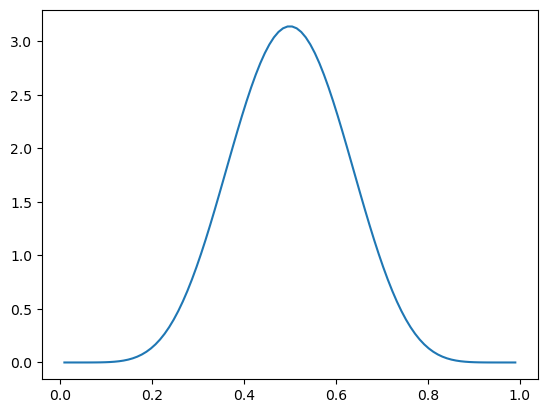

In [17]:
def plot_beta(a: float, b: float):
    x = torch.linspace(0.01,0.99,100)
    plt.plot(x, torch.distributions.Beta(a, b).log_prob(x).exp())
plot_beta(8,8)

* So, in the end, we have:
$\begin{align}
& z \in [0,1]: \text{ the fairness of the coin}\\
& x_i \in \{0, 1\}: \text{ whether the coin at trial } i \text{ lands heads}\\
& z \sim Beta(8,8) \\
& x_i|z \sim^{iid} Bernoulli(z)
\end{align}
$

## defining the model in `pyro`

In [18]:
from functools import partial

In [19]:
Bernoulli = partial(dist.Binomial, 1)

In [38]:
pyro.clear_param_store()
def coin_tossing_model(trials_results: torch.Tensor):
    # Set the initial parameters that influence the latent variable z
    a = pyro.param('a', torch.tensor(8.))
    b = pyro.param('b', torch.tensor(8.))
    
    # Set the latent variable
    z = pyro.sample('z', dist.Beta(a, b))
    
    # Define the observable variables (iid)
    with pyro.plate('data', len(trials_results)):
        return pyro.sample('x', Bernoulli(z), obs=trials_results)

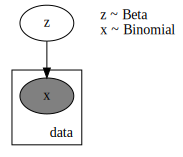

In [40]:
pyro.render_model(coin_tossing_model, [torch.ones((10,))], render_distributions=True)

makes sense!

## defining the guide

* the only requirement for defining the `guide` is that it should have the same support over $z$, i.e., $[0,1]$

* a simple choice is to use another beta distribution, only this time we'll try and tune the parameters $\phi=(\alpha, \beta)$

* so, we have $q_\phi(z)=q_{\alpha, \beta}(z)=beta(\alpha, \beta)$

* we actually know that the exact posterior is of this form, since the beta distribution is conjugate of the bernoulli

* ecco qua:

In [41]:
def coin_tossing_guide(trials_results: torch.Tensor):
    """guide must have the same signature as the corresponding model, even if it does not use it"""
    # Set variational parameters
    alpha = pyro.param('alpha', init=torch.tensor(15.), constraint=dist.constraints.positive)
    beta = pyro.param('beta', init=torch.tensor(15.), constraint=dist.constraints.positive)
    
    # Set variational distribution sample of z
    z = pyro.sample('z', dist.Beta(alpha, beta))
    

* **NOTE**:
    * model and guide have the same signature
    * guide also samples `'z'`, for its the name given to the latent variable defined in the model - which we are trying to infer upon
    * the guide does not have to return anything - it's the relashioship between the variables that interests us

## stochastic variational inference herself

### optimizer

* usually one uses adam - da best

In [46]:
from pyro.optim import Adam

In [47]:
optimizer = Adam({
    'lr': .0005,
    'betas': (.9, .999)
})

### loss

* the loss is basically the `ELBO` - that's what we're trying to minimize - `pyro` implements this via a class - to be studied!

In [48]:
from pyro.infer import Trace_ELBO

In [49]:
loss = Trace_ELBO()

### algorithm set up

In [50]:
from pyro.infer import SVI

In [51]:
svi = SVI(coin_tossing_model, coin_tossing_guide, optimizer, loss)

### training

#### format data

* given the sequence of trials (H, H, T, H, T, H, H, T, T, H)

In [43]:
data = torch.tensor((1., 1., 0., 1., 0., 1., 1., 0., 0., 1.))

In [44]:
data

tensor([1., 1., 0., 1., 0., 1., 1., 0., 0., 1.])

#### train

In [58]:
from pyro.infer.abstract_infer import TracePosterior

In [59]:
from array import array

In [63]:
# Set number of steps
def train(algorithm: SVI, 
          data: torch.Tensor, 
          number_steps: int) -> array:
    
    losses = array('f')
    
    for step in range(number_steps):
        # An svi.step is basically a forward and a backward - compute the loss and optimize
        loss = algorithm.step(data)
        losses.append(loss)
        if step % 100 == 0:
            log.info(f'Loss at step {step}: {loss}')

# Example: Geography and national income

### problem statement

* from `Statistical Rethinkin`

* Problem: investigate the relationship between a country's **terrain ruggedness** and its **GDP per capita** wrt whether the country belongs to the african continent or not

* We'll have a dataset coming from "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv", with relevant features:
    * `rugged`: quantifying the *terrain ruggedness index*
    * `cont_africa`: whether the given nation is in Africa
    * `rgdppc_2000`: GDP per capita for the year 2000

### data

In [ ]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [ ]:
df.head()

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113


### features engineering

In [ ]:
df.isna().sum()

cont_africa     0
rugged          0
rgdppc_2000    64
dtype: int64

<AxesSubplot:>

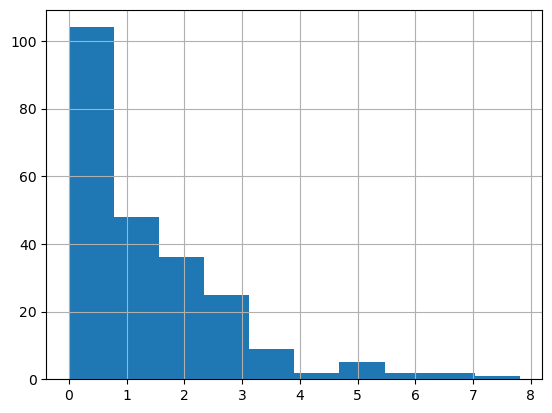

In [ ]:
df.rugged.hist()

<AxesSubplot:>

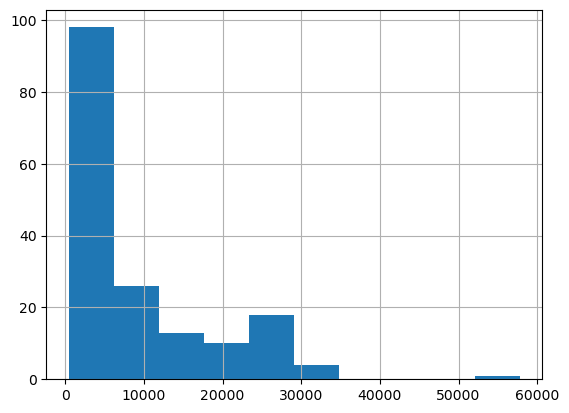

In [ ]:
df.rgdppc_2000.hist()

* **NOTE**:
    * since GDP is skewed, we log transform it
    * we drop na values

In [ ]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [ ]:
df.isna().sum()

cont_africa    0
rugged         0
rgdppc_2000    0
dtype: int64

<AxesSubplot:>

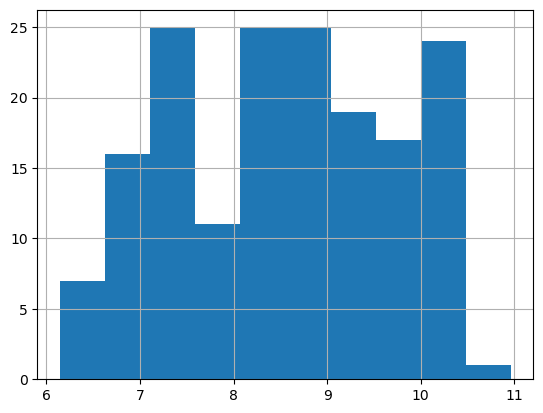

In [ ]:
df.rgdppc_2000.hist()

* **NOTE**:
    * for using `pyro`, we must grab data as `torch` tensors

In [ ]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

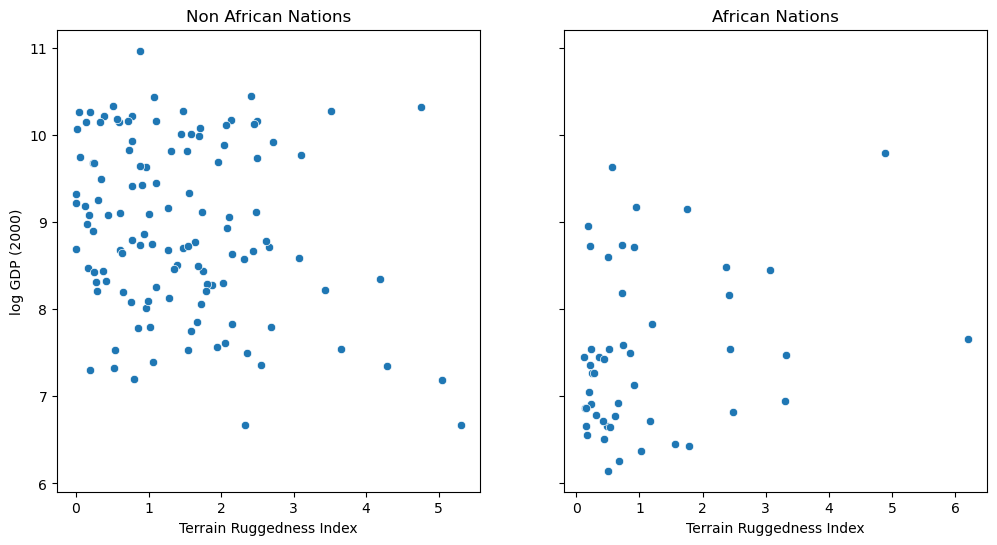

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");